# Fase 2: Processamentos 

Tema: Detecção de ruas utilizando algoritmos de processamento de imagens

Objetivo:

- Delimitar as bordas de ruas em vídeo;
- Comparar resultados utilizando apenas processamentos no OpenCV com a utilização de técnicas mais avançadas, como reconhecimento de imagens utilizando redes neurais convolucionais;
-  Considera-se, também, a fusão dos resultados de ambas as técnicas, a fim de avaliar se o resultado seria beneficiado ou não
- Em caso de sucesso, tentar calcular o ângulo relativo que o veículo deveria movimentar o volante de modo a se  manter na pista, para cada instante do vídeo.

Procura-se aplicar os resultados desse processamento em uma competição de carros autônomos em escala, na etapa em que só é permitido utilizar sensor de câmera para o controle da trajetória. Visto isso, pretende-se fazer um algoritmo que detecte as bordas das ruas no trajeto da competição em específico, com a possibilidade de testes em demais ambientes.

In [40]:
#Primeiras tentativas!!
#Approach 1: Hough Transform

#Possibilidades: Filtragem por cores, 
#Filtragem Sobel
#Equalização de histograma para processamento
#Região conexa
#Watershed transform
#Segmentação por limiarização?

Baseando-se na pipeline apresentada em [[1]](https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132), será testada a seguinte pipeline:

![Pipeline](https://miro.medium.com/max/1280/1*wVfCstrB_YLG_UZE3X5JLw.png)

O algoritmo apresentado é aplicável a ruas com faixas bem visíveis, e pretende-se utilizar variações da mesma para obter-se a segmentação da rua, ou ao menos a direção em que a rua está seguindo, para fins de controle.

Utilizando primeiramente imagens, e não o vídeo como um todo:

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
#Showfig padrão do prof.
def showfig(image):
    plt.figure(figsize=(6,6))
    imgplot=plt.imshow(image, 'gray')

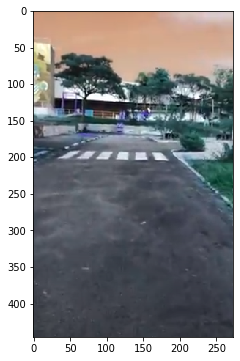

In [5]:
# Importar imagem
pista =cv2.imread('pista.png')
showfig(pista)

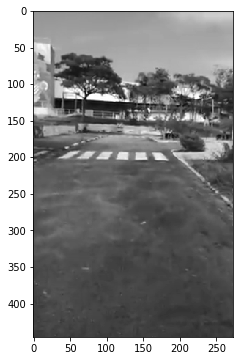

In [6]:
# To GrayScale
gray = cv2.cvtColor(pista, cv2.COLOR_BGR2GRAY)

showfig(gray)

In [45]:
gray.shape #Perdeu uma dimensão!

(446, 273)

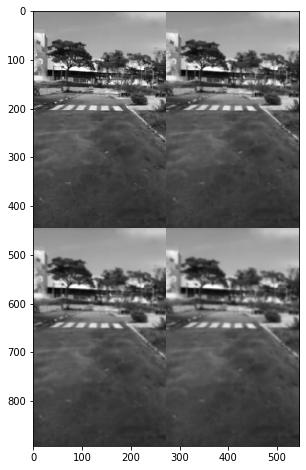

In [7]:
#Aplicando Gaussian Blur:  
blur1 = cv2.GaussianBlur(gray,(3,3),0 )
blur2 = cv2.GaussianBlur(gray,(5,5),0 )
blur3 = cv2.GaussianBlur(gray,(7,7),0 )
blur4 = cv2.GaussianBlur(gray,(9,9),0 )

output = np.vstack([ np.hstack([blur1,blur2]),
                 np.hstack([blur3,blur4])])

plt.figure(figsize=(8,8))
plt.imshow(output,'gray')

In [47]:
## Canny Edges: Como funciona? Explicar!

In [8]:
#Aplicar canny edges: Diferentes tamanhos do gaussiano!
canny1 = cv2.Canny(blur1,50,150)  #Definir os thresholds adequadamente?
canny2 = cv2.Canny(blur2,50,150)
canny3 = cv2.Canny(blur3,50,150) 
canny4 = cv2.Canny(blur4,50,150) #Canny já utiliza Gaussian Blur inbuilt

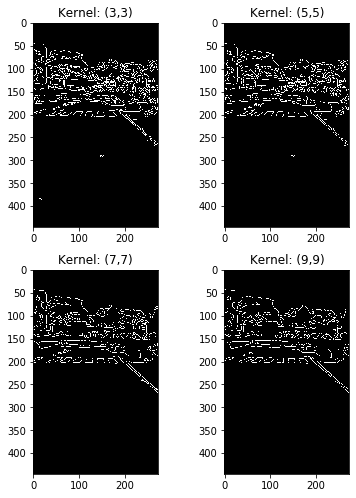

In [9]:
fig=plt.figure(figsize=(7,7))
col= 2
row= 2
imgs= [canny1, canny2, canny3, canny4]
#ax permite manipular cada um dos subplots de modo independente
ax=[]
for i in range(1,col*row+1):
    img =imgs[i-1]
    ax.append(fig.add_subplot(row,col,i))
    plt.imshow(img,'gray')
    ks = (2*(i-1)+3)
    ksize = np.array([(ks,ks)])
    ax[-1].set_title('Kernel: ('+str(ks)+','+str(ks)+')')
    #ax[-1].set_title("ax:"+str(i))
    plt.tight_layout(True) #Melhora a apresentação da image
    plt.savefig("Imagens\Kernels")
plt.show()


Me pareece que não houveram grandes diferenças entre os Kernels, sendo que o 9,9 apresentou menos artefatos, mantendo ainda assim a visibilidade da região de interesse, que é a linha da guia, pois apresenta a informação acerca da direção da rua.

De qualquer modo, a escolha do Threshold utilizado (Canny), pode definir resultados diferentes para cada Kernel. Será utilizado o Kernel (9,9).

A próxima etapa é a segmentação da rua, onde espera-se criar, primeiramente de modo manual, uma máscara próxima a região esperada de segmentação. A fim de evitar que o horizonte cause problemas para a detecção, grande parte da região superior da imagem será "ignorada".

In [50]:
#Criação de uma máscara com a região de interesse

In [10]:
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
 
    poly = np.array([[
    (0, height),
    (30,210),
    (200,205),
    (width,250),
    (width,height),]], np.int32)
 
    a = cv2.fillPoly(mask, poly, 255)
    plt.imshow(a,'gray')
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image
 

In [11]:
canny4.shape

(446, 273)

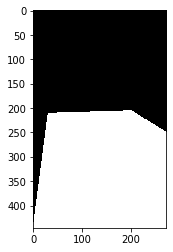

In [12]:
a = region_of_interest(canny4)
#plt.imshow(a,'gray')
#construção da máscara para definir região de interesse

In [54]:
#Aplicar dilatação da imagem/ morph opening

In [13]:
kernel = np.ones((3,3),np.uint8)
#Juntar as linhas da imagem
opening = cv2.morphologyEx(a,cv2.MORPH_CLOSE,kernel, iterations = 5)
# Crescer um pouco a região
#dilatado = cv2.dilate(a,kernel,iterations=1)

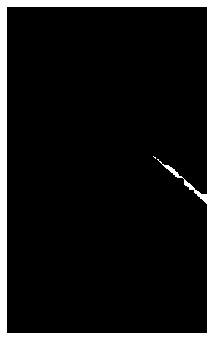

In [14]:
showfig(opening)
plt.axis("off")
plt.savefig("Imagens\lane1.pdf")


Aplicar Hough Transform: É uma técnica de transformação de retas em um espaço.
uma reta y=mx+b, por exemplo  y=3x+1 pode ser representada no espaço pelas coordenadas (3,1), enquanto um ponto no espaço de Hough é representado por infinitas retas. A idéia da técnica é utilizar vários pontos de entrada, a fim de obter a reta mais consistente com tais pontos. O espaço de Hough é dado em coordenadas polares, uma vez que existem pontos indefinidos para coordenadas cartesianas (ex: tan = 90).

[No OpenCV](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)

In [15]:
#Argumentos: Imagem,rho, theta, Thresholding: [,lines, min line lenght, maxline Gap ] -> return lines

linhas = cv2.HoughLinesP(opening, 2, np.pi/180, 100, np.array([]), minLineLength=10, maxLineGap=10)
print(linhas)
# Significado da saída:(x0,y0,x1,y1)

[[[210 215 272 265]]

 [[202 206 272 261]]

 [[219 217 272 263]]]


In [16]:
#def reta_média(image,line):
 #Alterar a representação da linha para (x0, m)
#Só to fazendo a reta da direita # Pq deu meio ruim 
line_fit=[]

for linha in linhas:
    for x1, y1, x2, y2 in linha:
        fit = np.polyfit((x1,x2), (y1,y2), 1)
        slope = fit[0]
        intercept = fit[1]
        line_fit.append((slope, intercept))

reta_media=np.average(line_fit,axis=0)

slope, intercept = reta_media    
y1 = 350#opening.shape[0]
y2 = int(y1*3/5)
x1= int((y1-intercept)/slope)
x2= int((y2-intercept)/slope)
coord = [x1,x2,y1,y2]

In [17]:
#Verificar a reta na imagem
line_image = np.zeros_like(pista)
line_image= cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)


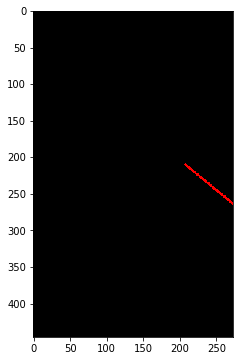

In [18]:
showfig(line_image)
#showfig(opening)
#Linha correspondente a borda da pista
plt.savefig("Imagens\lane2.pdf")


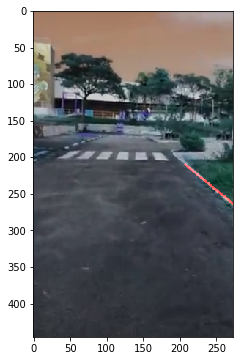

In [19]:
#Merge nas imagens
imagem = cv2.addWeighted(pista,0.8,line_image,1,1)
showfig(imagem)
plt.savefig("Imagens\lane_final.pdf")


In [ ]:
# Testando no vídeo o resultado: Consegui alguma generalização?
#Remontar o código inteiro dentro do cv.Capture --> rodar no console pq o cv.imshow não roda aqui

Código para o teste (Compilando os processamentos realizados)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)

    poly = np.array([[  # Polígono para fazer a máscara (feito sob medida da)
    (0, height),
    (30,210),
    (200,205),
    (width,250),
    (width,height),]], np.int32)

    cv2.fillPoly(mask, poly, 255) #return none --> preenche a região
    masked_image = cv2.bitwise_and(canny, mask) #Ou exclusivo para ignorar oq estiver fora da mask
    return masked_imag

cap = cv2.VideoCapture("pista.mp4") #colocar o vídeo

while(cap.isOpened()):
    ret, pista = cap.read() #Iniciando video

    s=1
    print("frame ",str(s))
    s=s+1
    gray = cv2.cvtColor(pista, cv2.COLOR_BGR2GRAY) #transforma para cinza
    blur4 = cv2.GaussianBlur(gray,(9,9),0 ) # aplicar blur
    canny4 = cv2.Canny(blur4,50,150)  # aplicar canny edges detector (um conjunto de operações)

    a = region_of_interest(canny4) #mascarar a região de interesse(na imagem foi feito no olho)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(a,cv2.MORPH_CLOSE,kernel, iterations = 5) #Suavizar e juntar as linhas
    linhas = cv2.HoughLinesP(opening, 2, np.pi/180, 100, np.array([]), minLineLength=10, maxLineGap=5)

    line_fit=[]
    if linhas is not None:
        oi=1
        for linha in linhas:
            for x1, y1, x2, y2 in linha:
                fit = np.polyfit((x1,x2), (y1,y2), 1)
                slope = fit[0]
                intercept = fit[1]
                line_fit.append((slope, intercept))

    reta_media=np.average(line_fit,axis=0)

    slope, intercept = reta_media    
    y1 = 350#opening.shape[0]
    y2 = int(y1*3/5)
    x1= int((y1-intercept)/slope)
    x2= int((y2-intercept)/slope)
    coord = [x1,x2,y1,y2]

    line_image = np.zeros_like(pista)
    line_image= cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)

    imagem = cv2.addWeighted(pista,0.8,line_image,1,1)
    cv2.imshow('resultado',pista)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()